In [1]:
import pandas as pd
import numpy as np
import os, sys, subprocess
import h5py
import json
import matplotlib.pyplot as plt

In [2]:
#import data from Sastry et. al. 
DATA_DIR = '../dataframes/'

DF_prest = pd.concat([pd.read_csv(DATA_DIR+'DF_prest_features_1.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_2.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_3.csv',index_col=0),
                      pd.read_csv(DATA_DIR+'DF_prest_features_4.csv',index_col=0)])
print ('Number of peptides:', len(DF_prest))


Number of peptides: 45206


In [3]:
DF_prest.head(5)

,prest_id,uniprot_id,conc_cf,aa_seq,nt_seq,aa_len,true_nt_seq,AAA,AAT,AAC,...,disembl_HOTLOOPS_frac,ronn_avg,ronn_results,ronn_frac,disopred_results,disopred_avg,disopred_pb_results,disopred_pb_avg,disopred_frac,disopred_pb_frac
0,140095,G3V3N0,4.3075,IMTAPSSFEQFKVAMNYLQLYNVPDCLEDIQDADCSSSKCSSSASS...,GACAAGCTTGCGGCCGCAATTATGACAGCTCCCTCCAGTTTTGAGC...,139,ATTATGACAGCTCCCTCCAGTTTTGAGCAGTTTAAAGTGGCAATGA...,0.057554,0.043165,0.021583,...,0.410072,0.495827,imtapssfeqfkvamnylqlynvpdclediqDADCSSSKCSSSASS...,0.482014,ImtapssfeqfkvamnylqlynvpdclediqdadcsSSKCSSSASS...,0.387050,-...................................^^^^^^^^^^...,0.317770,0.388489,0.359712
1,140099,G3V537,2.9154,TYYAWKHELLGSGTCPALPPREVLGMEELEKLPEEQVAEEELECSA...,GACAAGCTTGCGGCCGCAACCTACTATGCCTGGAAGCATGAGCTGC...,144,ACCTACTATGCCTGGAAGCATGAGCTGCTGGGCTCTGGCACCTGCC...,0.006944,0.013889,0.013889,...,0.388889,0.488125,tyyawkhellGSGTcPALPPREVLGMEELEKLPEEQVAEEELECSa...,0.493056,tyyawkhellgsgtCPALPPREVLGMEELEKLPEEQVAEEELECSA...,0.421597,..............^^^^^^--^^^^^^^^^^^^^^^^^^^-^^^^...,0.352917,0.465278,0.423611
2,140225,P12724,1.4877,SLHARPPQFTRAQWFAIQHISLNPPRCTIAMRAINNYRWRCKNQNT...,GACAAGCTTGCGGCCGCATCACTCCATGCCAGACCCCCACAGTTTA...,136,TCACTCCATGCCAGACCCCCACAGTTTACGAGGGCTCAGTGGTTTG...,0.007353,0.051471,0.058824,...,0.338235,0.368750,SLharppqftraqwfaiqhislnpprctiamrainnyrwrcknqnt...,0.058824,slharppqftraqwfaiqhislnpprctiamrainnyrwrcknqnt...,0.034338,.................................................,0.000000,0.000000,0.000000
3,140235,H0YH02,6.7224,ARALNESKRVNNGNTAPEDSSPAKKTRRCQRQESKKMPVAGGKANK...,GACAAGCTTGCGGCCGCAGCGAGAGCATTAAATGAAAGCAAAAGAG...,123,GCGAGAGCATTAAATGAAAGCAAAAGAGTTAATAATGGCAACACGG...,0.040650,0.056911,0.040650,...,0.552846,0.571382,ARALNESKRVNNGNTAPEDSSPAKKTRRCQRQESKKMPVAGGKANK...,0.536585,ARALNESKRVNNGNTAPEDSSPAKKTRRCQRQESKKMPVAGGKANK...,0.425366,^^^^^^^^^^^^^^^-^---^-^^^^^^^^^^^^^--^^^^^^^^^...,0.295122,0.430894,0.373984
4,140309,F5GYC5,3.3848,HRKEPGARLEATRGAARPHKQGTKPMITRPSVSQLGEGKCPSSQHL...,GACAAGCTTGCGGCCGCACATCGGAAAGAGCCTGGGGCAAGGCTGG...,124,CATCGGAAAGAGCCTGGGGCAAGGCTGGAGGCCACAAGAGGAGCTG...,0.032258,0.008065,0.008065,...,0.274194,0.556613,HRKEPGARLEATRGAARPHKQGTKPMITRPSVSQLGEGKCPSSQHL...,0.620968,HRKEPGARLEATRGAARPHKQGTkpmitrpsvsqlgegkcpssqhl...,0.236613,^^^^^^^^^^^^^^^^^^^^^^^^.........................,0.185726,0.201613,0.209677


# One hot encoding of AA sequence

In [4]:
# list of amino acid single letter abbreviations from https://en.wikipedia.org/wiki/Amino_acid
#aa_list = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

# amino acid list in order of hydropathy score from https://en.wikipedia.org/wiki/Hydrophilicity_plot
aa_list = ['I', 'V', 'L', 'F', 'C', 'M', 'A', 'G', 'T', 'S', 'W', 'Y', 'P', 'H', 'E', 'Q', 'D', 'N', 'K', 'R']

Make a dictionary for the encoding (with abbreviations sorted in alpabetical order)

In [6]:
# create a dictionary
aa_one_hot = {}
for idx, aa in enumerate(aa_list): 
    one_hot = np.zeros(len(aa_list))
    one_hot[idx] = 1
    aa_one_hot[aa] = list(one_hot)  

In order to avoid the need to pad the data later we will make all one hot encodings the same length

In [7]:
max(DF_prest['aa_len'])

149

In [8]:
def aa_to_one_hot_matrix(aa_seq):
    
    one_hot_matrix = np.zeros([149, 20]) # maximum aa_seq length X number of amino acids 
    for idx, aa in enumerate(aa_seq):
        one_hot_matrix[idx] = np.array(aa_one_hot[aa])
        
    return one_hot_matrix

Make a new dataframe that only has the info needed for the one hot encoding and apply the encoding function to the entire dataset

In [9]:
df_aa_one_hot = pd.DataFrame()
df_aa_one_hot['prest_id'] = DF_prest['prest_id']
df_aa_one_hot['conc_cf'] = DF_prest['conc_cf']
df_aa_one_hot['aa_one_hot'] = DF_prest['aa_seq'].apply(aa_to_one_hot_matrix)

Vizulaize an example sequence.  Note that the right hand side is empty (this is padding so all data is the same shape)

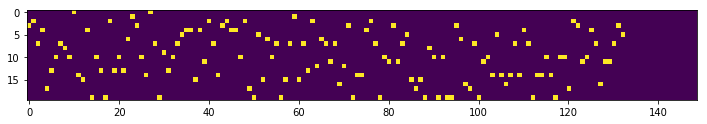

In [9]:
ind = 5000
plt.figure(figsize=(12, 8))
plt.imshow(np.rot90(df_aa_one_hot['aa_one_hot'][ind]))

Split the data into high and low expression

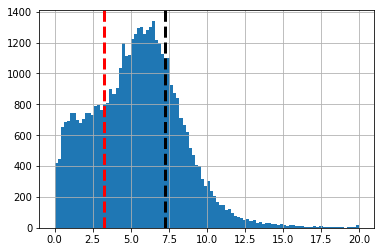

In [10]:
df_aa_one_hot['conc_cf'].hist(bins=100)
plt.axvline(df_aa_one_hot['conc_cf'].quantile(.75), color='k', linestyle='dashed', linewidth=3)
plt.axvline(df_aa_one_hot['conc_cf'].quantile(.25), color='r', linestyle='dashed', linewidth=3)

In [11]:
# identify high and low classes by conc_cf quantiles
low_cut = df_aa_one_hot['conc_cf'].quantile(0.25)
high_cut = df_aa_one_hot['conc_cf'].quantile(0.75)

low_exp_df = df_aa_one_hot[df_aa_one_hot['conc_cf'] < low_cut]
high_exp_df = df_aa_one_hot[df_aa_one_hot['conc_cf'] > high_cut]

# set classes for high vs. low expression# set cl 
low_exp_df.insert(0, 'class', 0)
high_exp_df.insert(0, 'class', 1)
#doing it this was causes a warning
# low_exp_df['class'] = 0
# high_exp_df['class'] = 1

print(low_exp_df.shape, high_exp_df.shape)

aa_one_hot_highlow = pd.concat([low_exp_df,high_exp_df])


(11302, 4) (11301, 4)


In [16]:
aa_one_hot_highlow.to_hdf('aa_one_hot_highlow.h5', 'data')

/Users/prg/miniconda3/lib/python3.6/site-packages/pandas/core/generic.py:1471: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['aa_one_hot']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Maybe it would be better to convert everthign to np arrays for storage?